In [435]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon
from tqdm import tqdm

In [836]:
class withdrawal:
    def __init__(self):
        self.value = 0
        self.requested = 0
        self.processed = 0

In [1052]:
# constraints = [
#     (10, 4),  # no more than 10 wdraws in  4 epochs
#     (20, 10), # no more than 20 wdraws in 10 epochs
# ]

constraints = [
    (2, 1),  # no more than 2 wdraws in  1 epochs
    (3, 3),  # no more than 3 wdraws in  3 epochs
]

In [1053]:
T_MAX = max(constraints, key=lambda x:x[1])[1]
T_MAX

3

In [1054]:
uniform.rvs(), expon.rvs(1)

(0.9108530361667535, 1.6149194742477189)

In [1058]:
history = []
pending = []
results = []
perepoch = []
for t in tqdm(range(20)):
    # Expire oldest withdrawals
    history = [h for h in history if (t - h[1]) <= T_MAX]
    
    # Calc minslack
    slacks = []
    for c in constraints:
        delta_i, t_i = c
        relevant_history = [h for h in history if (t - h[1]) < t_i]
        slack_i = delta_i - len(relevant_history)
        slacks.append(slack_i)
    minSlack = min(slacks)
    print(minSlack)
    perepoch.append(minSlack)
    
    # Process withdrawals
    withdrawals = pending[:minSlack]
    newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
    results.extend(newResults)
    history.extend([(w[0], t) for w in withdrawals])
    pending = pending[minSlack:]
    
    # Add new pendings
    numWdraws = poisson.rvs(mu=8)
    newValues = uniform.rvs(0, 1, size=numWdraws)
    newPending = [(vi, t) for vi in newValues]
    pending.extend(newPending)

results = np.asarray(results)

100%|██████████| 20/20 [00:00<00:00, 3962.69it/s]

2
2
1
0
2
1
0
2
1
0
2
1
0
2
1
0
2
1
0
2


In [1059]:
np.mean(perepoch)

1.1

In [1034]:
df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()
reduced.head()

,buckets,avgs
0,"(0.33, 0.34]",1.100000
1,"(0.85, 0.86]",1.272727
2,"(0.53, 0.54]",1.166667
3,"(0.7, 0.71]",1.090909
4,"(0.8, 0.81]",1.000000


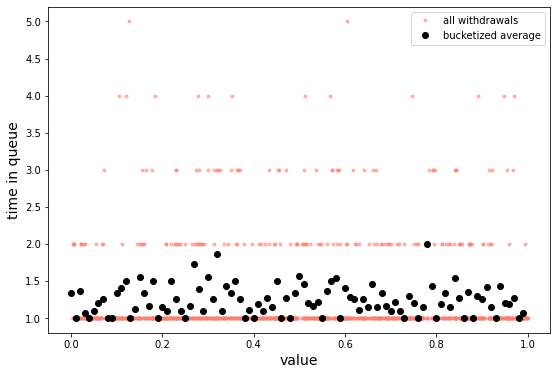

In [1035]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
        linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

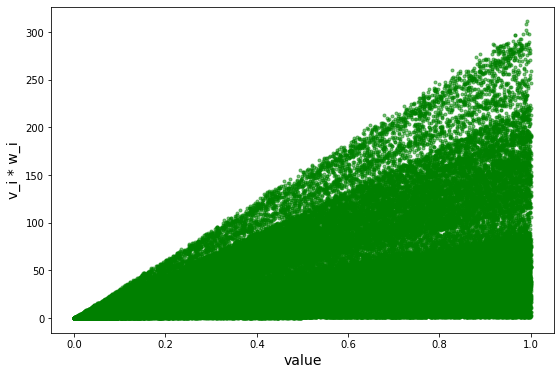

In [899]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(results[:,0], results[:,0] * results[:,1], 
        linestyle="none", marker='.', color='green', alpha=0.5)

ax.set_xlabel('value', size=14)
ax.set_ylabel('v_i * w_i', size=14)
plt.show()

In [900]:
np.mean(results[:,0] * results[:,1])

42.18093403950085

# proportional minslack

In [560]:
for alpha in [0.25, 0.5, 0.75, 1]:
    history = []
    pending = []
    results = []
    for t in range(10_000):
        # Expire oldest withdrawals
        history = [h for h in history if (t - h[1]) > T_MAX]
        
        # Calc minslack
        slacks = []
        for c in constraints:
            delta_i, t_i = c
            relevant_history = [h for h in history if h[1] <= t_i]
            slack_i = delta_i - len(relevant_history)
            slacks.append(slack_i)
        minSlack = min(slacks)
        propMinSlack = int(minSlack * alpha)
        # print("history {}, pending {}, ms {}, pms {}".format(history, pending, minSlack, propMinSlack))

        # Process withdrawals
        withdrawals = pending[:propMinSlack]
        newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
        results.extend(newResults)
        history.extend([(w[0], t) for w in withdrawals])
        pending = pending[minSlack:]
    
        # Add new pendings
        numWdraws = poisson.rvs(mu=8)
        newValues = expon.rvs(0.3, size=numWdraws)
        newPending = [(vi, t) for vi in newValues]
        pending.extend(newPending)

        # Pending needs to be sorted now
        pending.sort(reverse=True, key=lambda x:x[0])
        
        # print("history {}, pending {}, ms {}, pms {}".format(history, pending, minSlack, propMinSlack))
        # print("wdraws {}, pendingnew {}".format(withdrawals, pending))

    results = np.asarray(results)
    print("alpha={}, weighted mean={}".format(alpha, np.mean(results[:,0] * results[:,1])))

alpha=0.25, weighted mean=2.475644616759217
alpha=0.5, weighted mean=1.7313082649501532
alpha=0.75, weighted mean=1.49528573583069
alpha=1, weighted mean=1.3431687548861595


In [561]:
len(pending)

14

In [551]:
df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, max(results[:,0]), 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()
reduced.head()

,buckets,avgs
0,"(4.2, 4.21]",1.000000
1,"(2.83, 2.84]",1.000000
2,"(2.38, 2.39]",1.000000
3,"(1.39, 1.4]",1.000000
4,"(0.88, 0.89]",1.019093


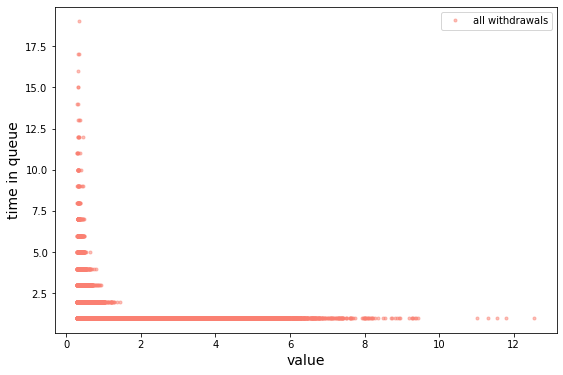

In [552]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
# ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
#         linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

In [485]:
np.mean(results[:,0] * results[:,1])

1.5676226074572364

In [160]:
df.buckets.values[:]

[(0.71, 0.72], (0.02, 0.03], (0.49, 0.5], (0.49, 0.5], (0.93, 0.94], ..., (0.47, 0.48], (0.67, 0.68], (0.12, 0.13], (0.64, 0.65], (0.36, 0.37]]
Length: 4937
Categories (100, interval[float64]): [(0.0, 0.01] < (0.01, 0.02] < (0.02, 0.03] < (0.03, 0.04] ... (0.96, 0.97] < (0.97, 0.98] < (0.98, 0.99] < (0.99, 1.0]]

In [165]:
df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()
reduced.head()

,buckets,avgs
0,"(0.71, 0.72]",5.744681
1,"(0.02, 0.03]",5.350000
2,"(0.49, 0.5]",6.686275
4,"(0.93, 0.94]",5.608696
5,"(0.64, 0.65]",6.551724


<BarContainer object of 100 artists>

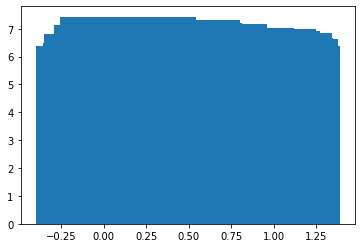

In [191]:
plt.bar([b.left for b in reduced['buckets'].values], reduced['avgs'])

In [150]:
df.groupby('buckets')['times'].transform('mean')

0       5.744681
1       5.350000
2       6.686275
3       6.686275
4       5.608696
          ...   
4932    6.345455
4933    6.637931
4934    5.824561
4935    6.551724
4936    6.300000
Name: times, Length: 4937, dtype: float64

In [992]:
history = []
pending = []
results = []

In [993]:
t=0

In [994]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

2

In [995]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend([(w[0], t) for w in withdrawals])
pending = pending[minSlack:]
history, pending

([], [])

In [996]:
# Add new pendings
numWdraws = poisson.rvs(mu=10)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([],
 [(0.33809753760303074, 0),
  (0.7232209906358794, 0),
  (0.4319109863214047, 0),
  (0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0)])

In [997]:
t=1

In [998]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

2

In [999]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend([(w[0], t) for w in withdrawals])
pending = pending[minSlack:]
history, pending

([(0.33809753760303074, 1), (0.7232209906358794, 1)],
 [(0.4319109863214047, 0),
  (0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0)])

In [1000]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.33809753760303074, 1), (0.7232209906358794, 1)],
 [(0.4319109863214047, 0),
  (0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0)])

In [1001]:
t=2

In [1002]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[(0.33809753760303074, 1), (0.7232209906358794, 1)]

In [1003]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

1

In [1004]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend([(w[0], t) for w in withdrawals])
pending = pending[minSlack:]
history, pending

([(0.33809753760303074, 1), (0.7232209906358794, 1), (0.4319109863214047, 2)],
 [(0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0)])

In [1005]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.33809753760303074, 1), (0.7232209906358794, 1), (0.4319109863214047, 2)],
 [(0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0),
  (0.6967037909637617, 2)])

In [1006]:
t=3

In [1007]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[(0.33809753760303074, 1), (0.7232209906358794, 1), (0.4319109863214047, 2)]

In [1008]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

0

In [1009]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend([(w[0], t) for w in withdrawals])
pending = pending[minSlack:]
history, pending

([(0.33809753760303074, 1), (0.7232209906358794, 1), (0.4319109863214047, 2)],
 [(0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0),
  (0.6967037909637617, 2)])

In [1010]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.33809753760303074, 1), (0.7232209906358794, 1), (0.4319109863214047, 2)],
 [(0.25860820646527216, 0),
  (0.8807662105893167, 0),
  (0.4983191952648651, 0),
  (0.9272267755782196, 0),
  (0.37208767241033147, 0),
  (0.9728572312371845, 0),
  (0.6719518480453671, 0),
  (0.46643496262932294, 0),
  (0.16847746369187866, 0),
  (0.6500841778127634, 0),
  (0.6967037909637617, 2),
  (0.09637508504536274, 3),
  (0.9969732653357753, 3),
  (0.8329954174729222, 3),
  (0.9021274726368268, 3),
  (0.17730267150638213, 3)])

In [1011]:
t=4

In [1012]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[(0.33809753760303074, 1), (0.7232209906358794, 1), (0.4319109863214047, 2)]

In [1013]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

0

In [816]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend(withdrawals)
pending = pending[minSlack:]
history, pending

([(0.3193783625585024, 1), (0.55258756118677, 1), (0.30556473899788883, 2)],
 [(0.7065200250294877, 3), (0.12991191504035682, 3)])

In [817]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.3193783625585024, 1), (0.55258756118677, 1), (0.30556473899788883, 2)],
 [(0.7065200250294877, 3),
  (0.12991191504035682, 3),
  (0.7402221941233551, 4),
  (0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4)])

In [818]:
t=5

In [819]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[(0.30556473899788883, 2)]

In [820]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

2

In [821]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend(withdrawals)
pending = pending[minSlack:]
history, pending

([(0.30556473899788883, 2), (0.7065200250294877, 3), (0.12991191504035682, 3)],
 [(0.7402221941233551, 4),
  (0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4)])

In [822]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.30556473899788883, 2), (0.7065200250294877, 3), (0.12991191504035682, 3)],
 [(0.7402221941233551, 4),
  (0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5)])

In [823]:
t=6

In [824]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[(0.7065200250294877, 3), (0.12991191504035682, 3)]

In [825]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

1

In [826]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend(withdrawals)
pending = pending[minSlack:]
history, pending

([(0.7065200250294877, 3), (0.12991191504035682, 3), (0.7402221941233551, 4)],
 [(0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5)])

In [827]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.7065200250294877, 3), (0.12991191504035682, 3), (0.7402221941233551, 4)],
 [(0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5),
  (0.8368518182141633, 6),
  (0.20562957801453907, 6),
  (0.28284804555560084, 6),
  (0.3341172243046805, 6)])

In [828]:
t=7

In [829]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[(0.7402221941233551, 4)]

In [830]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

2

In [831]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend(withdrawals)
pending = pending[minSlack:]
history, pending

([(0.7402221941233551, 4), (0.005814512606337696, 4), (0.8625104780574232, 4)],
 [(0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5),
  (0.8368518182141633, 6),
  (0.20562957801453907, 6),
  (0.28284804555560084, 6),
  (0.3341172243046805, 6)])

In [832]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.7402221941233551, 4), (0.005814512606337696, 4), (0.8625104780574232, 4)],
 [(0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5),
  (0.8368518182141633, 6),
  (0.20562957801453907, 6),
  (0.28284804555560084, 6),
  (0.3341172243046805, 6),
  (0.7729846858340922, 7)])

In [833]:
t=8

In [834]:
history = [h for h in history if (t - h[1]) <= T_MAX]
history

[]

In [825]:
# Calc minslack
slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (t - h[1]) <= t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
minSlack

1

In [826]:
# Process withdrawals
withdrawals = pending[:minSlack]
newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
results.extend(newResults)
history.extend(withdrawals)
pending = pending[minSlack:]
history, pending

([(0.7065200250294877, 3), (0.12991191504035682, 3), (0.7402221941233551, 4)],
 [(0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5)])

In [827]:
# Add new pendings
numWdraws = poisson.rvs(mu=2)
newValues = uniform.rvs(0, 1, size=numWdraws)
newPending = [(vi, t) for vi in newValues]
pending.extend(newPending)
history, pending

([(0.7065200250294877, 3), (0.12991191504035682, 3), (0.7402221941233551, 4)],
 [(0.005814512606337696, 4),
  (0.8625104780574232, 4),
  (0.604733139223019, 4),
  (0.5764183191138279, 4),
  (0.5450065054350886, 5),
  (0.562821559487976, 5),
  (0.8368518182141633, 6),
  (0.20562957801453907, 6),
  (0.28284804555560084, 6),
  (0.3341172243046805, 6)])